In [1]:
%load_ext autoreload
%autoreload 2

import os
import jax

os.chdir("..")
import numpy as np
from flax import serialization

from src.c3po.analysis.analysis import C3poAnalysis
from src.c3po.model.model import C3PO

# analysis=C3poAnalysis(None, None, None)

# Loading

## Load in data objects

In [18]:
import numpy as np
from scipy.io import loadmat

data = loadmat(
    # "/stelmo/sam/c3po_results/moserdata.mat"
    "/stelmo/sam/c3po_datasets/moser_mec_25843_2_openfield.mat"
)  # in the downloadable Vollan archive, this is 27765_2.mat  (potentially can do this with any other data file)


def mat_fields(s):
    """Return field names for a MATLAB struct (np.void or structured ndarray)."""
    if isinstance(s, np.ndarray) and s.dtype.names:
        return s.dtype.names
    if isinstance(s, np.void) and s.dtype.names:
        return s.dtype.names
    raise TypeError("Not a MATLAB struct (np.void/structured ndarray).")


# The 'Dsession' key gives the main struct
Dsession = data["Dsession"]

t = Dsession["t"][0, 0].flatten()  # times
x = Dsession["x"][0, 0].flatten()  # x positions
y = Dsession["y"][0, 0].flatten()  # y positions
speed = Dsession["speed"][0, 0].flatten()  #
thetaphase = Dsession["theta"][0, 0].flatten()  #
units = Dsession["units"][0, 0].flatten()  # unit data (more parsing below)
unit_cluster_id = units["mec"][0]["acorrCluId"][:]

head_dir = Dsession["hd"][0, 0].flatten()

In [4]:
t_spikes = np.arange(t[0], t[-1], 0.002)
spikes = []
for uu in range(len(units["mec"][0]["spikeTimes"])):
    spikes.append(units["mec"][0]["spikeTimes"][uu][0].flatten())

len(spikes)


from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

smoothing_window = 0.02  # in seconds
dt = t_spikes[1] - t_spikes[0]
smoothing_window_bins = int(smoothing_window / dt)
rates = []

for uu in tqdm(range(len(spikes))):
    rate, _ = np.histogram(
        spikes[uu], bins=np.concatenate([t_spikes, [t_spikes[-1] + (dt)]])
    )
    # rate = np.convolve(
    #     rate,
    #     np.ones(smoothing_window_bins) / smoothing_window_bins,
    #     mode="same",
    # )
    rate = gaussian_filter1d(
        rate[:, None].astype("float"),
        sigma=smoothing_window_bins,
        axis=0,
        mode="nearest",
    )

    rates.append(rate / (t[1] - t[0]))  # in Hz
rates = np.squeeze(rates).T

100%|██████████| 1522/1522 [01:36<00:00, 15.74it/s]


In [5]:
# plt.hist(np.log10(np.diff(t)))
# plt.yscale("log")
# np.median(np.diff(t))
dt = np.diff(t)

ind_valid = (dt < 0.02).astype(int)  # only use intervals with dt < 20 ms
starts = np.where(np.diff(ind_valid) == 1)[0] + 1
ends = np.where(np.diff(ind_valid) == -1)[0] + 1
if ind_valid[0]:
    starts = np.insert(starts, 0, 0)
if ind_valid[-1]:
    ends = np.append(ends, len(ind_valid))
valid_intervals = [[t[s], t[e]] for s, e in zip(starts, ends)]

## Load in encoding results

In [ ]:
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()  # .alter()
# key = {"model_name": "mec_wavenet_all_cells"}
key = dict(model_name="mec_wavenet_25843_all_cells")

analysis = (C3POStorage & key).fetch_analysis_object()

analysis.load_embedding(f"/stelmo/sam/c3po_results/{key['model_name']}_embedding.npz")

t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca()

# Just showing how to access the variables
# t = analysis.t
z = analysis.z
c = analysis.c
c_pca = analysis.c_pca
t_interp = analysis.t_interp
c_interp = analysis.c_interp
c_pca_interp = analysis.c_pca_interp

entry = (C3POStorage & key).fetch1()
latent_dim = entry["latent_dim"]
context_dim = entry["context_dim"]

[2025-12-17 14:56:49,996][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-12-17 14:56:50,020][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


# Analysis

In [8]:
import matplotlib.pyplot as plt
from spyglass.common.common_interval import Interval

### Plot example

[5.12783570e+01 1.81073155e+01 1.34696077e+01 1.00630146e+01
 4.80502902e+00 9.16644582e-01 7.18143799e-01 1.59265383e-01
 1.48234646e-01 1.24349130e-01 6.62032039e-02 4.54237497e-02
 3.18303777e-02 3.05275398e-02 2.15498194e-02 1.45039663e-02]


Text(0, 0.5, 'context variables')

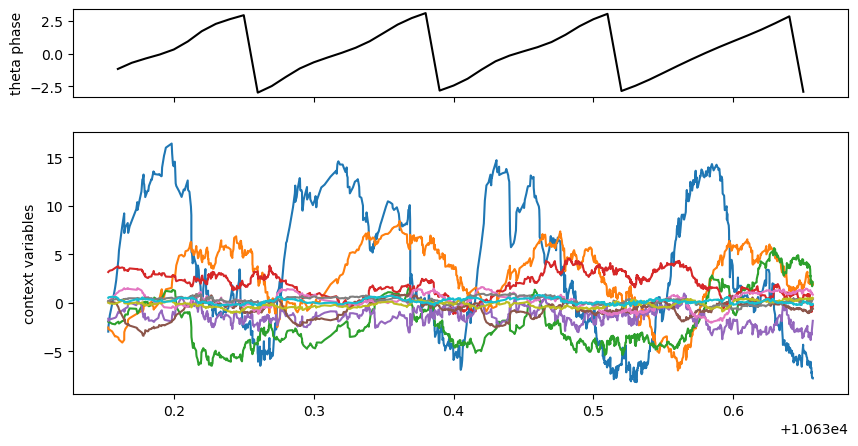

In [9]:
fig, ax = plt.subplots(nrows=2, sharex=True, height_ratios=[1, 3], figsize=(10, 5))
ind = slice(11000, 12300)
# ind = slice(12000,12300)

ax[1].plot(analysis.t[ind], analysis.c_pca[ind, :10])
plot_interval = Interval(np.array([[analysis.t[ind][0], analysis.t[ind][-1]]]))
behavior_inds = plot_interval.contains(t, as_indices=True)
ax[0].plot(t[behavior_inds], thetaphase[behavior_inds], c="k")
print(analysis.pca.explained_variance_ratio_ * 100)
ax[0].set_ylabel("theta phase")
ax[1].set_ylabel("context variables")

### Average context value vs phase

Text(0.5, 0, 'Theta phase (rad)')

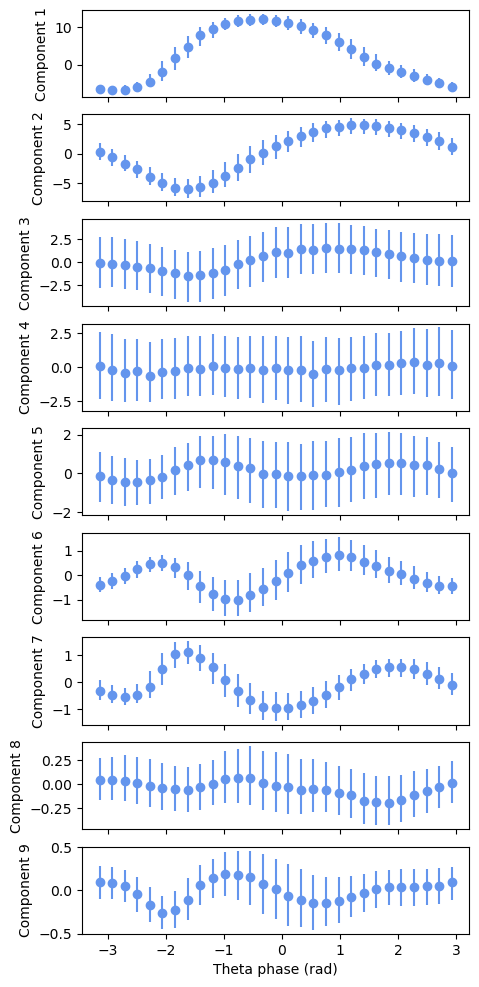

In [ ]:
context_binned, bins = analysis.bin_context_by_feature(
    thetaphase, t, bins=np.linspace(-np.pi, np.pi, 30), pca=True
)

fig, ax = plt.subplots(nrows=9, sharex=True, figsize=(5, 12))
for dat, loc in zip(context_binned, bins):
    for i, a in enumerate(ax):
        color = "cornflowerblue"
        a.scatter(loc, np.nanmedian(dat[:, i]), c=color)
        a.vlines(
            loc,
            np.nanpercentile(dat[:, i], 25),
            np.nanpercentile(dat[:, i], 75),
            color=color,
        )
for i, a in enumerate(ax):
    a.set_ylabel(f"Component {i+1}")
plt.xlabel("Theta phase (rad)")

In [ ]:
t.size, t_interp.size, ind_data.size, analysis.t.size, ind_phase.size

(130000, 2659851, 130000, 1273703, 1273703)

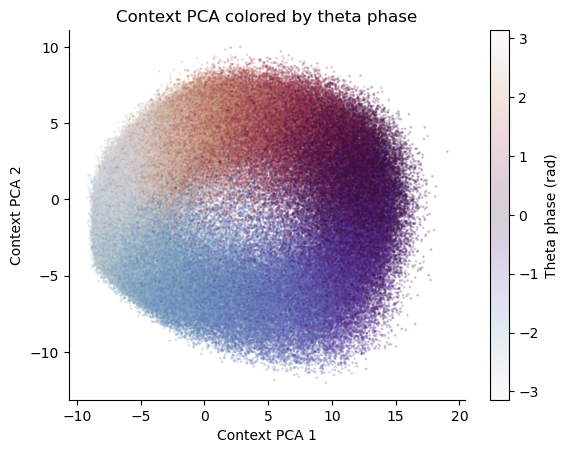

In [ ]:
plot_dims = [0, 3]
plot_dims = [0, 1]

subset = slice(None, None, 10)

fig = plt.figure()
ind_phase = np.digitize(analysis.t, t)
# ind_data = ind_data[subset]
plt.scatter(
    c_pca[subset][:, plot_dims[0]],
    c_pca[subset][:, plot_dims[1]],
    s=1,
    alpha=0.2,
    c=thetaphase[ind_phase[subset] - 1],
    cmap="twilight",
)
plt.colorbar(label="Theta phase (rad)")
plt.xlabel(f"Context PCA {plot_dims[0]+1}")
plt.ylabel(f"Context PCA {plot_dims[1]+1}")
plt.title("Context PCA colored by theta phase")
fig.gca().spines[["top", "right"]].set_visible(False)

### Context value vs. head_dir

Text(0.5, 0, 'Theta phase (rad)')

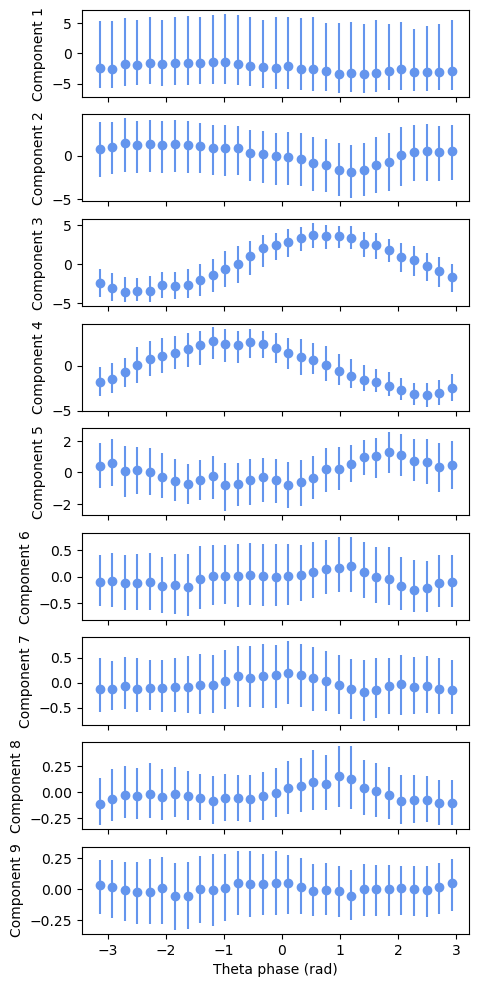

In [ ]:
context_binned, bins = analysis.bin_context_by_feature(
    head_dir, t, bins=np.linspace(-np.pi, np.pi, 30), pca=True
)

fig, ax = plt.subplots(nrows=9, sharex=True, figsize=(5, 12))
for dat, loc in zip(context_binned, bins):
    for i, a in enumerate(ax):
        color = "cornflowerblue"
        a.scatter(loc, np.nanmedian(dat[:, i]), c=color)
        a.vlines(
            loc,
            np.nanpercentile(dat[:, i], 25),
            np.nanpercentile(dat[:, i], 75),
            color=color,
        )
for i, a in enumerate(ax):
    a.set_ylabel(f"Component {i+1}")
plt.xlabel("Theta phase (rad)")

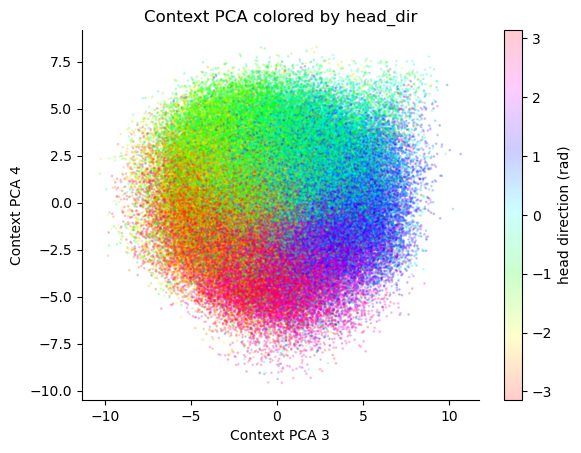

In [ ]:
plot_dims = [1, 2]
plot_dims = [2, 3]
subset = slice(None, None, 20)

fig = plt.figure()
ind_dir = np.digitize(analysis.t, t)
# ind_data = ind_data[subset]
plt.scatter(
    c_pca[subset][:, plot_dims[0]],
    c_pca[subset][:, plot_dims[1]],
    s=1,
    alpha=0.2,
    c=head_dir[ind_dir[subset] - 1],
    cmap="hsv",
)
plt.colorbar(label="head direction (rad)")
plt.xlabel(f"Context PCA {plot_dims[0]+1}")
plt.ylabel(f"Context PCA {plot_dims[1]+1}")
plt.title("Context PCA colored by head_dir")
fig.gca().spines[["top", "right"]].set_visible(False)

### 2d density distribution of context variables

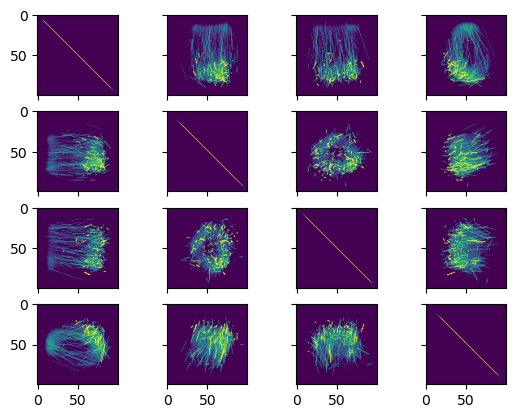

In [24]:
c_pca = analysis.c_pca_interp
# ind = running_intervals.contains(analysis.t, as_indices=True)
# ind = no_gap_intervals.contains(analysis.t_interp, as_indices=True)
ind = np.arange(c_pca.shape[0])

n_plot = 4
fig, ax = plt.subplots(nrows=n_plot, ncols=n_plot, sharex="col", sharey="row")

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        pc_ind = (i, j)
        H, bx, by = np.histogram2d(
            c_pca[ind, pc_ind[0]], c_pca[ind, pc_ind[1]], bins=100
        )
        H += 1e-3
        H = H / H.sum()
        H = np.log10(H)

        ax[i, j].imshow(H, clim=(-4, -3))
# plt.colorbar()

# plt.scatter(c_pca_interp[ind, 4], c_pca_interp[ind, 2], s=1, alpha=0.01)
# plt.scatter(c_pca_interp[ind, 2], c_pca_interp[ind, 3], s=1, alpha=0.1)

### Average Context values vs 2d position

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


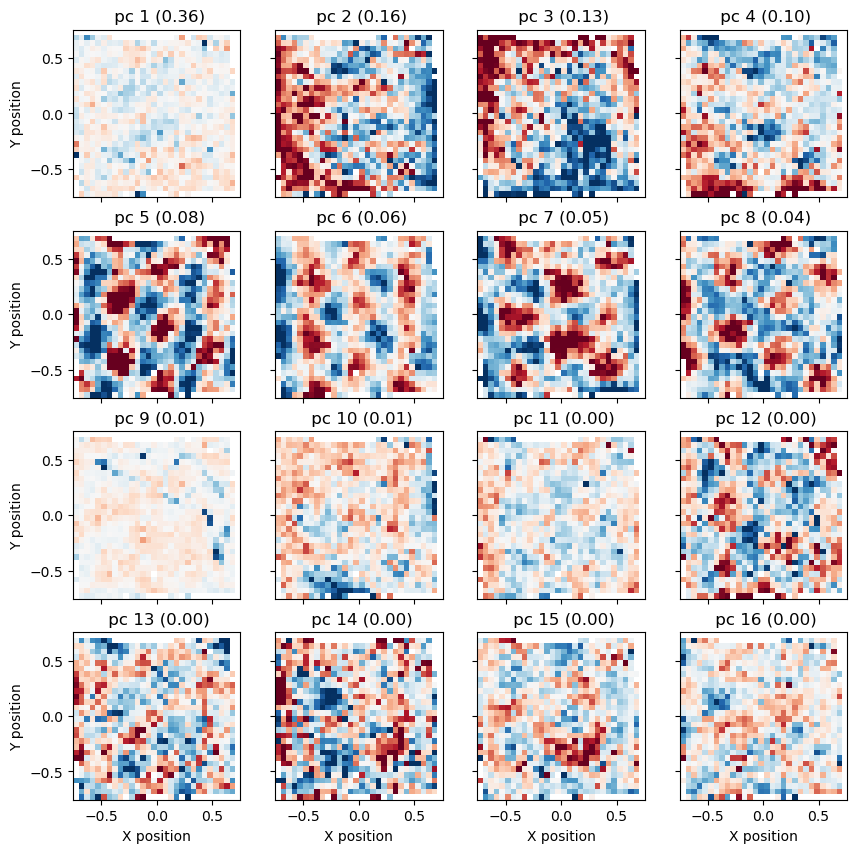

In [60]:
bins = np.linspace(np.min(x), np.max(x), 30)
c_binned, bins_x, bins_y = analysis.bin_context_by_feature_2d(
    x, t, y, t, pca=True, bins_1=bins, bins_2=bins
)
h = np.zeros(
    (bins_x.size, bins_y.size, analysis.context_dim),
)

for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if len(c_binned[i][j]) == 0:
            h[i, j] = np.nan
        h[i, j] = np.mean(c_binned[i][j], axis=0)

fig, ax = plt.subplots(
    nrows=min(4, analysis.latent_dim),
    ncols=4,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)
for i, a in enumerate(ax.ravel()):
    if i >= analysis.context_dim:
        break
    c_rng = np.nanmax(np.abs(h[:, :, i])) * 0.5
    a.imshow(
        h[:, :, i].T,
        aspect=1,
        origin="lower",
        extent=(bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]),
        cmap="RdBu",
        clim=(-c_rng, c_rng),
    )
    # a.set_title(f"Latent dimension {i+1}")
    # a.set_xlabel("X position (cm)")
    a.set_title(f" pc {i+1} ({analysis.pca.explained_variance_ratio_[i]:.2f})")

for a in ax[:, 0]:
    a.set_ylabel("Y position")


for a in ax[-1, :]:
    a.set_xlabel("X position")

### Power Spectrums

In [ ]:
f, mid, lo, hi = analysis.power_spectrum(
    intervals=valid_intervals, window_size=4000, nfft=100000
)

(0.0, 20.0)

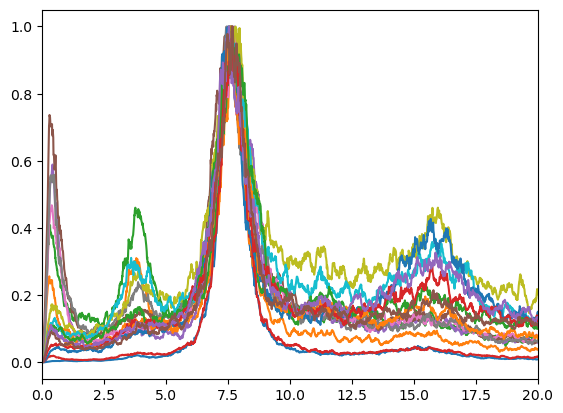

In [ ]:
y_plot = mid.T * f[:, None]
y_plot = y_plot / np.max(y_plot, axis=0)

plt.plot(f, y_plot)
plt.xlim(0, 20)
# plt.xlim(6,9)
# plt.xscale('log')
# plt.yscale('log')

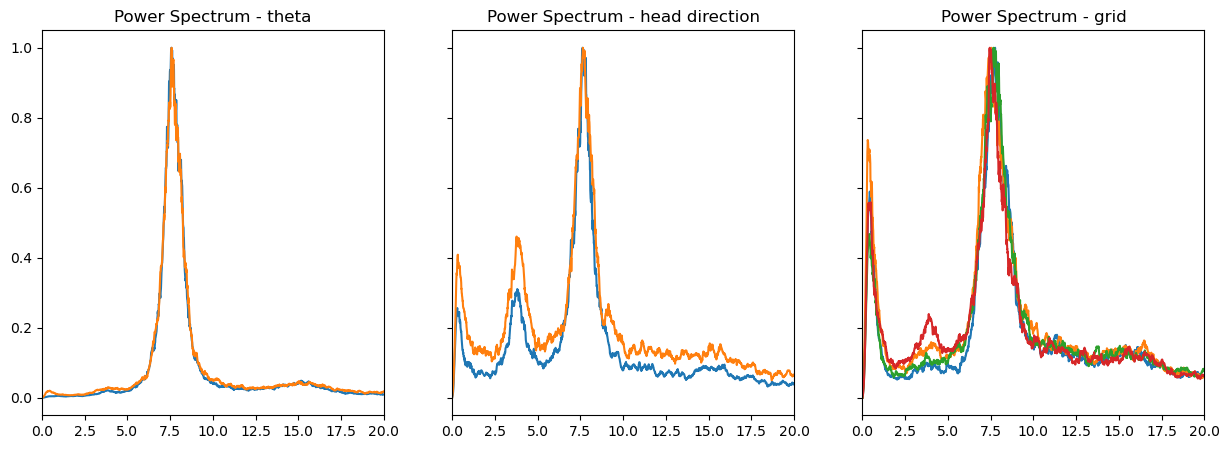

In [ ]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))

dim_groups = {
    "theta": [0, 3],
    "head direction": [1, 2],
    "grid": [4, 5, 6, 7],
}
y_plot = mid.T * f[:, None]
y_plot = y_plot / np.max(y_plot, axis=0)

for i, (group_name, dims) in enumerate(dim_groups.items()):
    ax[i].plot(f, y_plot[:, dims])
    ax[i].set_title(f"Power Spectrum - {group_name}")
    ax[i].set_xlim(0, 20)

In [13]:
# Aside: Head direction power spectrum
f, mid, lo, hi = analysis.power_spectrum(
    intervals=valid_intervals,
    window_size=400,
    nfft=10000,
    sourced_data=(t, head_dir[:, None]),
)

Text(0.5, 1.0, 'Head Direction Power Spectrum')

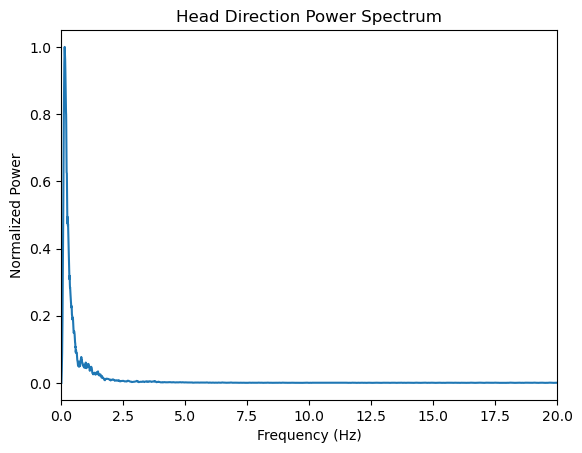

In [ ]:
y_plot = mid.T * f[:, None]
y_plot = y_plot / np.max(y_plot, axis=0)
plt.plot(f, y_plot)
plt.xlim(0, 20)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Power")
plt.title("Head Direction Power Spectrum")

### Cross-correlations

In [355]:
lags, xcorrs = analysis.cross_correlation(
    intervals=valid_intervals, processes=32, max_lag_seconds=2.0
)

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 256/256 [00:21<00:00, 11.96it/s]


In [114]:
xcorrs.shape

(16, 16, 1999)

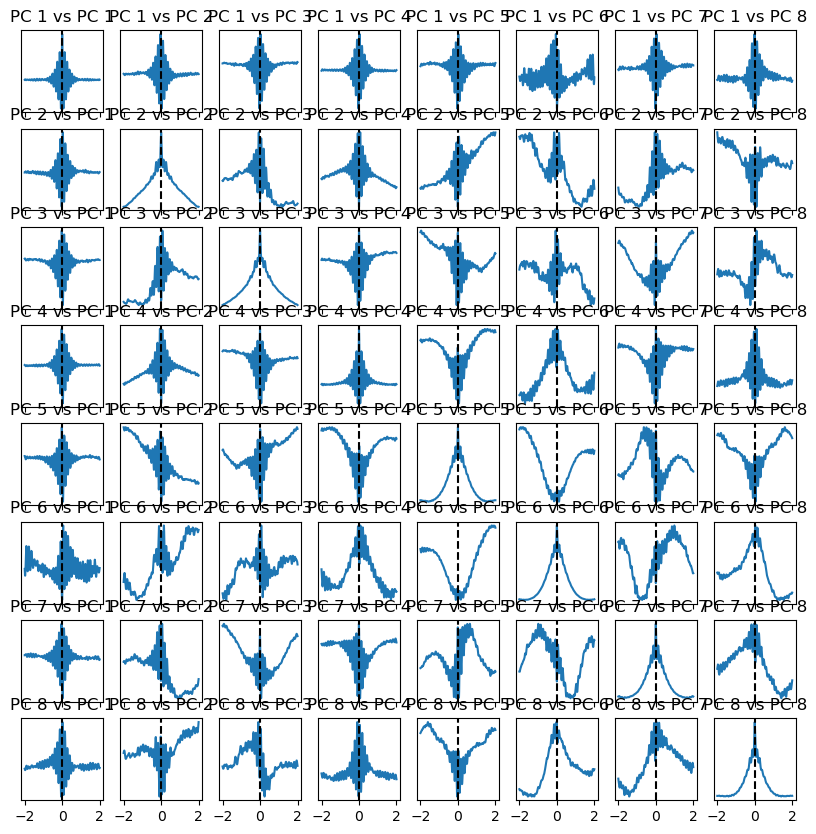

In [ ]:
n_plot = 8

fig, ax = plt.subplots(nrows=n_plot, ncols=n_plot, sharex=True, figsize=(10, 10))
for i in range(n_plot):
    for j in range(n_plot):
        ax[i, j].plot(lags, xcorrs[i, j, :])
        ax[i, j].set_title(f"PC {i+1} vs PC {j+1}")
        ax[i, j].axvline(0, c="k", ls="--")
        ax[i, j].set_yticks([])

# plt.xlim(-.5, .5)

Text(0, 0.5, 'Cross-covariance')

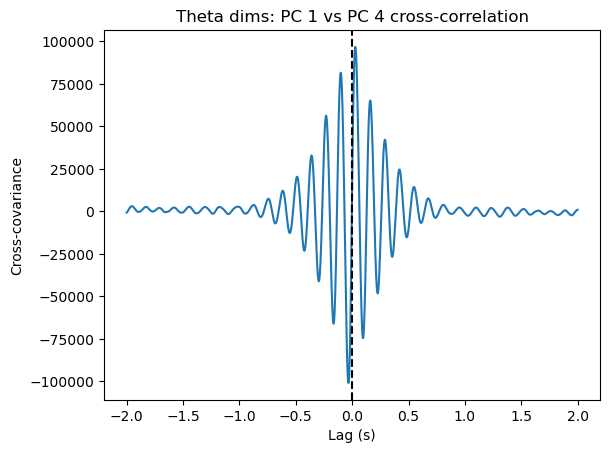

In [ ]:
# Theta phase xcorrelations
dims = [0, 3]

plt.plot(lags, xcorrs[dims[0], dims[1], :])
plt.title(f"Theta dims: PC {dims[0]+1} vs PC {dims[1]+1} cross-correlation")
plt.axvline(0, c="k", ls="--")
# plt.xlim(-.5,.5)

plt.xlabel("Lag (s)")
plt.ylabel("Cross-covariance")

Text(0, 0.5, 'Cross-covariance')

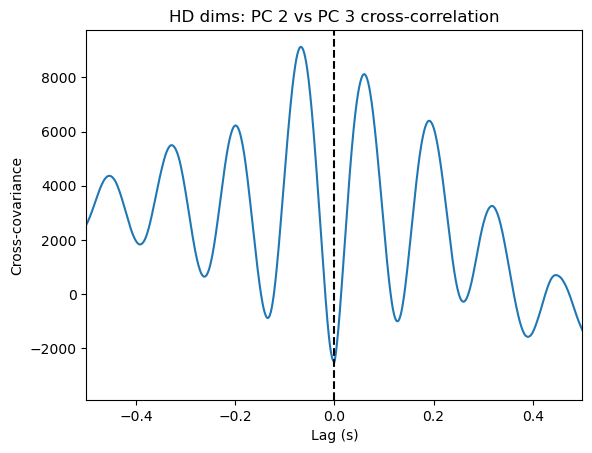

In [362]:
# head_dir xcorrelations
dims = [1, 2]

plt.plot(lags, xcorrs[dims[0], dims[1], :])
plt.title(f"HD dims: PC {dims[0]+1} vs PC {dims[1]+1} cross-correlation")
plt.axvline(0, c="k", ls="--")
plt.xlim(-0.5, 0.5)
# plt.xlim(-1,1)

plt.xlabel("Lag (s)")
plt.ylabel("Cross-covariance")

Text(0.5, 0.98, 'Grid cell dimensions cross-correlations')

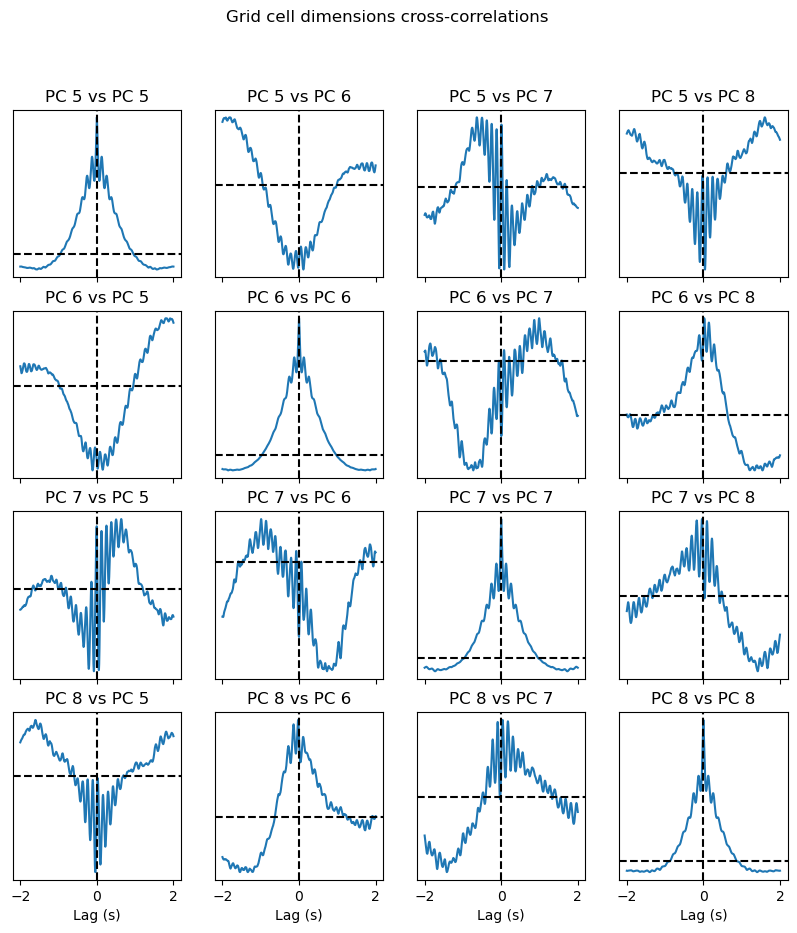

In [ ]:
# grid cell xcorrs

dims = [4, 5, 6, 7]
fig, ax = plt.subplots(nrows=len(dims), ncols=len(dims), sharex=True, figsize=(10, 10))
for i in range(len(dims)):
    for j in range(len(dims)):
        ax[i, j].plot(lags, xcorrs[dims[i], dims[j], :])
        ax[i, j].set_title(f"PC {dims[i]+1} vs PC {dims[j]+1}")
        ax[i, j].axvline(0, c="k", ls="--")
        ax[i, j].axhline(0, c="k", ls="--")
        ax[i, j].set_yticks([])

for a in ax[-1, :]:
    a.set_xlabel("Lag (s)")
# plt.xlim(-.5, .5)
fig.suptitle("Grid cell dimensions cross-correlations")

### Similarity matrix of neuron embeddings

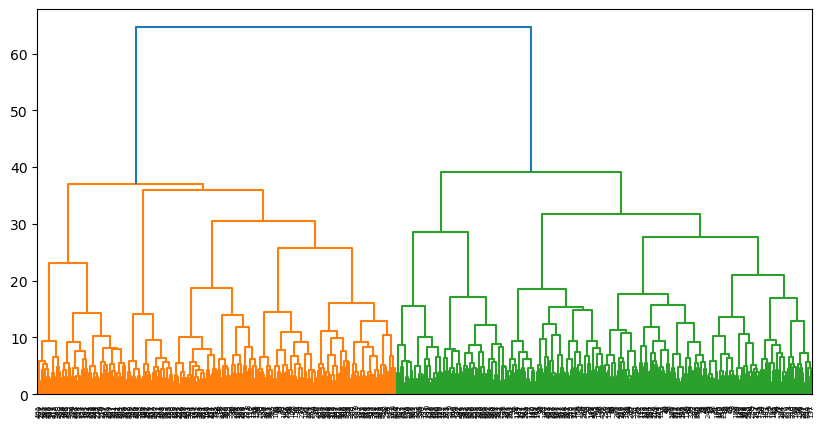

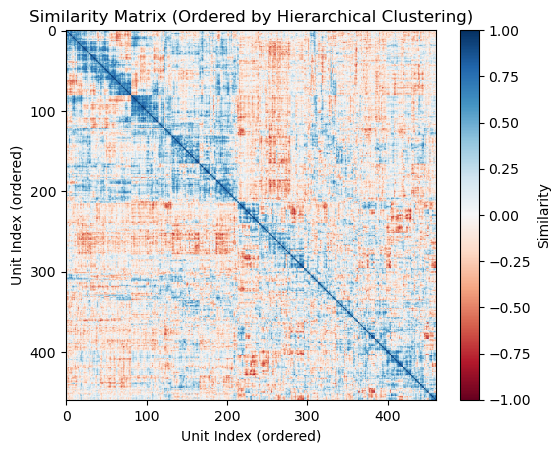

In [36]:
params = analysis.params
embed_matrix = params["params"]["embedding"]["encoder"]["encoder_matrix"]

# embed_matrix = params["params"]["rate_prediction"]["W_0"]
# embed_matrix = analysis.pca.transform(embed_matrix)

embed_matrix = embed_matrix / np.linalg.norm(embed_matrix, axis=1, keepdims=True)
sim = embed_matrix @ embed_matrix.T

# plt.imshow(sim, cmap="RdBu", vmin=-1, vmax=1)
# plt.colorbar()

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import leaves_list
from sklearn.cluster import SpectralClustering

# Perform hierarchical clustering on the similarity matrix
linked = linkage(sim, method="ward")
order = leaves_list(linked)

# Plot dendrogram
# plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(
    nrows=1,
    height_ratios=[
        1,
    ],
    figsize=(10, 5),
    sharex=True,
)
dendrogram(linked, ax=ax)
# ax[0].set_title("Hierarchical Clustering Dendrogram")
# ax[0].set_xlabel("Unit Index")
# ax[0].set_ylabel("Distance")

# plt.figure(figsize=(8, 8))
# order = np.squeeze(np.argsort(np.squeeze(unit_cluster_id)))
c_rng = 1
fig = plt.figure()
plt.imshow(sim[order][:, order], aspect=1, cmap="RdBu", clim=(-c_rng, c_rng))
plt.title("Similarity Matrix (Ordered by Hierarchical Clustering)")
plt.xlabel("Unit Index (ordered)")
plt.ylabel("Unit Index (ordered)")
plt.colorbar(label="Similarity")
plt.show()

### Movie

1292it [13:56,  1.54it/s]


KeyboardInterrupt: 

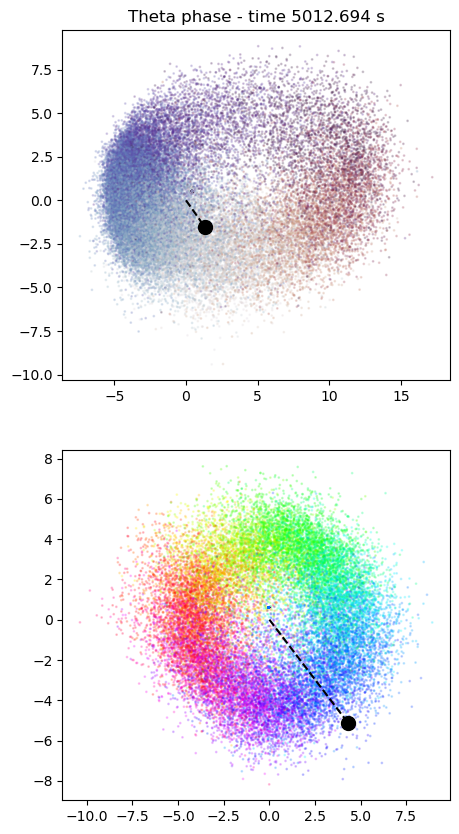

In [ ]:
output_dir = "/home/sambray/Documents/c3po/results/mec_embedding_vid"
os.makedirs(output_dir, exist_ok=True)
fig, ax = plt.subplots(nrows=2, height_ratios=[1, 1], figsize=(5, 10))


from tqdm import tqdm

theta_ax = ax[0]
hd_ax = ax[1]


theta_dims = [0, 3]
subset = slice(None, None, 30)
ind_phase = np.digitize(analysis.t, t)
theta_ax.scatter(
    c_pca[subset][:, theta_dims[0]],
    c_pca[subset][:, theta_dims[1]],
    s=1,
    alpha=0.2,
    c=thetaphase[ind_phase[subset]],
    cmap="twilight",
    rasterized=True,
)


hd_dims = [1, 2]
subset = slice(None, None, 50)
ind_dir = np.digitize(analysis.t, t)
# ind_data = ind_data[subset]
hd_ax.scatter(
    c_pca[subset][:, hd_dims[0]],
    c_pca[subset][:, hd_dims[1]],
    s=1,
    alpha=0.2,
    c=head_dir[ind_phase[subset]],
    cmap="hsv",
    rasterized=True,
)


for interval in valid_intervals:
    if interval[0] < 5000:
        continue
    if interval[1] - interval[0] > 1:
        break


i = np.digitize(interval[0] + 0, analysis.t)
scatter_ = []
lines_ = []
for ax, dims in zip([theta_ax, hd_ax], [theta_dims, hd_dims]):
    scatter_.append(
        ax.scatter(analysis.c_pca[i, dims[0]], analysis.c_pca[i, dims[1]], c="k", s=100)
    )
    lines_.append(
        ax.plot(
            [0, analysis.c_pca[i, dims[0]]],
            [0, analysis.c_pca[i, dims[1]]],
            c="k",
            ls="--",
        )
    )


t_plot = np.arange(interval[0], interval[1], 0.002)
for idx, t_i in tqdm(enumerate(t_plot)):
    theta_ax.set_title(f"Theta phase - time {t_i:.3f} s")
    i = np.digitize(t_i, analysis.t_interp)
    for j, dims in enumerate([theta_dims, hd_dims]):
        scatter_[j].set_offsets(
            [analysis.c_pca_interp[i, dims[0]], analysis.c_pca[i, dims[1]]]
        )
        lines_[j][0].set_data(
            [0, analysis.c_pca_interp[i, dims[0]]], [0, analysis.c_pca[i, dims[1]]]
        )
    fig.savefig(os.path.join(output_dir, f"frame_{idx:04d}.png"))

## Decoding

In [ ]:
t_feature = t
feature = head_dir[:, None]

# analysis.initialize_decoder(
#     model_type="knn",
#     n_neighbors=30,
#     weights="uniform",
#     # weights="distance",
#     metric="cosine",
# )
analysis.initialize_decoder(
    "discretized_regression",
    n_bins=100,
    max_iter=1000,
    balance_groups=True,
    multidim=False,
)


analysis.fit_decoder(
    feature,
    t_feature,
    intervals=valid_intervals,
    pca=True,
    decode_dim=slice(1, 3),
    interpolate=True,
    smooth_context=1,
)

-3.141565 3.141478
(130000, 1) (130000, 2)
-3.141565 3.141478


/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
for interval in valid_intervals:
    if interval[0] < 5000:
        continue
    if interval[1] - interval[0] > 1:
        break

t_pred, feature_pred = analysis.predict_decoder(
    interval, interpolate=True, smooth_context=1
)

Text(0.5, 0, 'Time (s)')

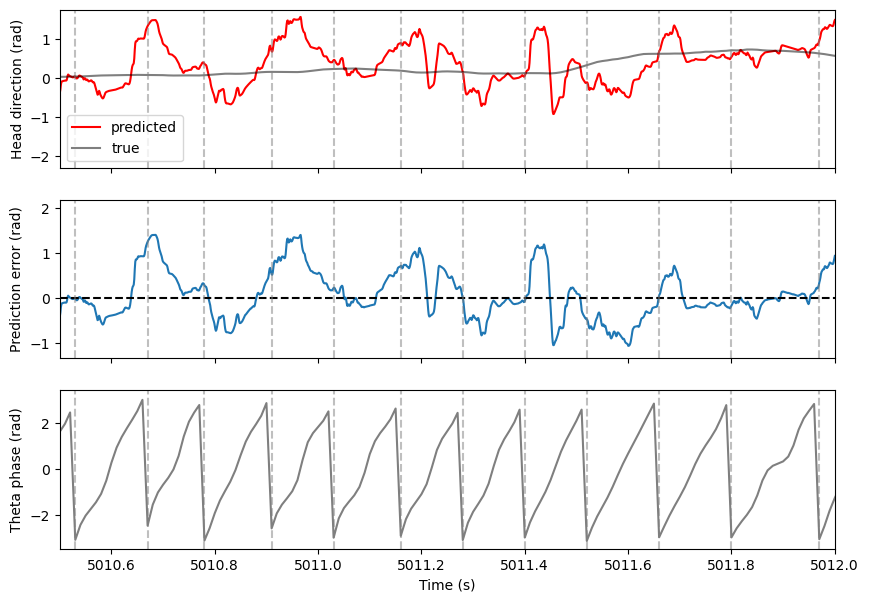

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 7))


pred_ax = ax[0]
err_ax = ax[1]
theta_ax = ax[2]

pred_ax.plot(t_pred, feature_pred, c="r", label="predicted")
feature_ind = np.logical_and(t_feature >= interval[0], t_feature <= interval[1])
xx = t_feature[feature_ind]
yy = feature[feature_ind]
pred_ax.plot(xx, yy, c="k", alpha=0.5, label="true")
pred_ax.legend()

ind_map = np.digitize(t_pred, t_feature)
error = feature_pred - feature[ind_map]
err_ax.plot(t_pred, error)
err_ax.axhline(0, c="k", ls="--")

theta_ax.plot(t_feature[feature_ind], thetaphase[feature_ind], c="k", alpha=0.5)


delta_theta = np.diff(thetaphase[feature_ind], prepend=0)
ind_mark = np.where(np.abs(delta_theta) > np.pi)[0]
for im in ind_mark:
    for a in ax:
        a.axvline(t_feature[feature_ind][im], c="gray", ls="--", alpha=0.5)

plt.xlim(5010.5, 5012)

pred_ax.set_ylabel("Head direction (rad)")
err_ax.set_ylabel("Prediction error (rad)")
theta_ax.set_ylabel("Theta phase (rad)")
plt.xlabel("Time (s)")

# Neuron basis decomposition

In [246]:
params = analysis.params
embed_matrix = np.array(params["params"]["embedding"]["encoder"]["encoder_matrix"])

pca_matrix = analysis.pca.components_

embed_matrix = embed_matrix @ pca_matrix.T

# W = params["params"]["rate_prediction"]["W_0"]
# embed_matrix = analysis.pca.transform(embed_matrix)

# embed_matrix = embed_matrix / np.linalg.norm(embed_matrix, axis=1, keepdims=True)
# sim = embed_matrix @ embed_matrix.T

# print(embed_matrix[0,0])
# neuron_order = np.argsort(-(np.abs(embed_matrix[:,:]).argmax(axis=1)))
# embed_matrix = embed_matrix[neuron_order]
# print(embed_matrix[0, 0])

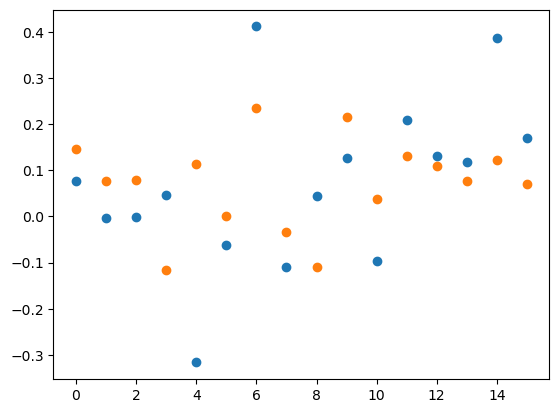

In [ ]:
i = 1  # neuron to analyze


plt.scatter(np.arange(context_dim), embed_matrix[i])

i = 2  # neuron to analyze


plt.scatter(np.arange(context_dim), embed_matrix[i])

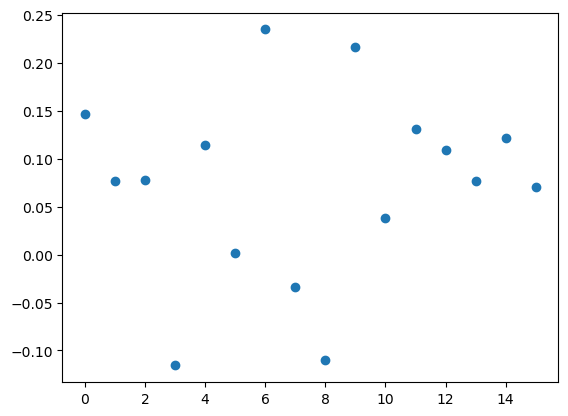

In [348]:
spike_id = 129
plt.scatter(np.arange(context_dim), embed_matrix[i])

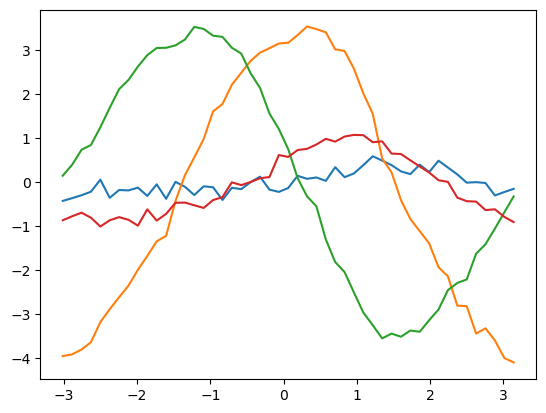

In [ ]:
n_bins = 50
t_feature = t
feature = head_dir

context_binned, bins = analysis.bin_context_by_feature(
    feature, t_feature, bins=np.linspace(-np.pi, np.pi, n_bins), pca=True
)

c_feature_mean = np.array([np.mean(cb, axis=0) for cb in context_binned])

plt.plot(bins[1:], np.array(c_feature_mean)[:, :4])

# fig, ax = plt.subplots(nrows=9, sharex=True, figsize=(5, 12))
# for dat, loc in zip(context_binned, bins):
#     for i, a in enumerate(ax):
#         color = "cornflowerblue"
#         a.scatter(loc, np.median(dat[:, i]), c=color)

In [ ]:
# rates_binned, bins = analysis.bin_context_by_feature(
#     feature, t_feature, bins=np.linspace(-np.pi, np.pi, n_bins),
#     alt_data=(t_spikes[::], rates[::, spike_id][:,None])
# )

# rates_feature_mean = np.array([np.mean(rb, axis=0) for rb in rates_binned])

# mua = rates.mean(axis=1)
# mua_binned, bins = analysis.bin_context_by_feature(
#     feature, t_feature, bins=np.linspace(-np.pi, np.pi, n_bins),
#     alt_data=(t_spikes[::], mua[:, None])
# )
# mua_feature_mean = np.array([np.mean(mb, axis=0) for mb in mua_binned])


mua = rates.mean(axis=1)
rel_rate = rates[:, spike_id] / mua
rel_rate_binned, bins = analysis.bin_context_by_feature(
    feature,
    t_feature,
    bins=np.linspace(-np.pi, np.pi, n_bins),
    alt_data=(t_spikes[::], rel_rate[:, None]),
)
rel_rate_feature_mean = np.array([np.nanmean(rb, axis=0) for rb in rel_rate_binned])

/tmp/ipykernel_1750199/2645108550.py:17: RuntimeWarning: invalid value encountered in divide
  rel_rate = rates[:, spike_id] / mua


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.10535634,
        0.12662834],
       [0.        , 0.        , 0.        , ..., 0.        , 0.91284401,
        0.09357724],
       [0.        , 0.        , 0.        , ..., 0.        , 0.74461053,
        0.06830428]])

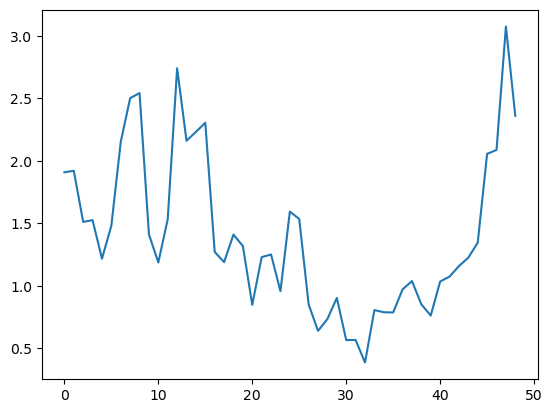

In [351]:
# plt.plot(rates_feature_mean)
# plt.plot(mua_feature_mean, c="k", lw=2)
plt.plot(rel_rate_feature_mean)
rates

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.10535634,
        0.12662834],
       [0.        , 0.        , 0.        , ..., 0.        , 0.91284401,
        0.09357724],
       [0.        , 0.        , 0.        , ..., 0.        , 0.74461053,
        0.06830428]])

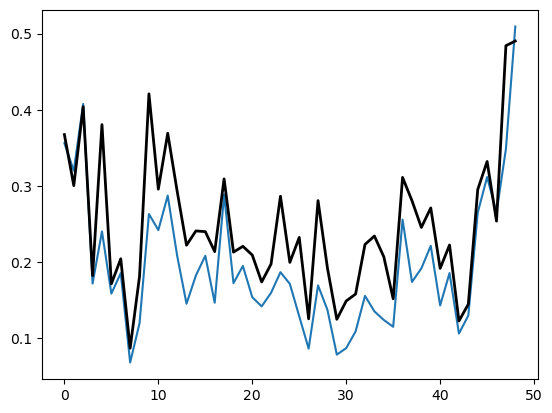

In [ ]:
plt.plot(rates_feature_mean)
plt.plot(mua_feature_mean, c="k", lw=2)
rates

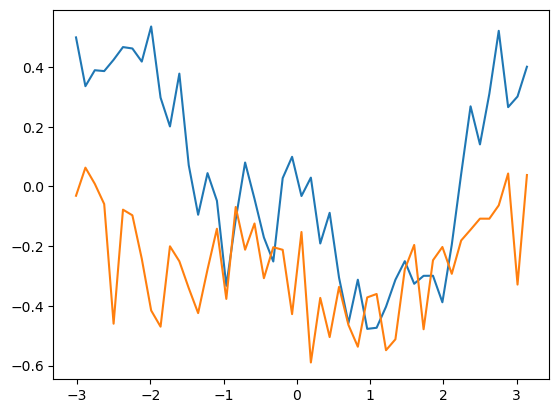

In [ ]:
c_feature_mean.shape, embed_matrix[spike_id].shape

predicted_field = c_feature_mean @ embed_matrix[spike_id]

empirical_field = rates_feature_mean
empirical_field = np.log(empirical_field / mua_feature_mean)
# empirical_field = np.log(rel_rate_feature_mean)

plt.plot(bins[1:], predicted_field)
plt.plot(bins[1:], empirical_field)